# Data Scientist Case Study

Submitted by: Emmanuel De Los Reyes <br>
Date: 26-Jan-2025

# 1. Load Data

In [11]:
import pandas as pd

xls = pd.ExcelFile('DataScientist_CaseStudy_Dataset.xlsx')

df_demog =pd.read_excel(xls, "Soc_Dem")
df_prod_bal =pd.read_excel(xls, "Products_ActBalance")
df_inout =pd.read_excel(xls, "Inflow_Outflow")
df_target =pd.read_excel(xls, "Sales_Revenues")


# 2. Sanity Checks and High Level Exploratory Data Analysis

### 2A. Data Checks / Cleaning

In [12]:
## Check number of duplicate records
print(f'{df_demog.duplicated().sum()} demog duplicate records ')
print(f'{df_prod_bal.duplicated().sum()} prod/bal duplicate records ')
print(f'{df_inout.duplicated().sum()} in out duplicate records ')
print(f'{df_target.duplicated().sum()} target duplicate records ')



0 demog duplicate records 
0 prod/bal duplicate records 
0 in out duplicate records 
0 target duplicate records 


In [13]:
# check for class imbalance
# Calculate the share of MF class
total_count = len(df_target)
MF_class_counts = df_target['Sale_MF'].value_counts()
MF_class_share = MF_class_counts / total_count

# Calculate the share of MF class
CC_class_counts = df_target['Sale_CC'].value_counts()
CC_class_share = CC_class_counts / total_count

# Calculate the share of CL class
CL_class_counts = df_target['Sale_CL'].value_counts()
CL_class_share = CL_class_counts / total_count

# Display the share of each class
print(MF_class_share)
print(CC_class_share)
print(CL_class_share)



Sale_MF
0    0.800826
1    0.199174
Name: count, dtype: float64
Sale_CC
0    0.750258
1    0.249742
Name: count, dtype: float64
Sale_CL
0    0.700722
1    0.299278
Name: count, dtype: float64


In [14]:

print('demog dataset')
print(df_demog.describe())
print('--------------------------------------------', "\n")

print('df_prod_bal dataset')
print(df_prod_bal.describe())
print('--------------------------------------------', "\n")

print('df_inout dataset')
print(df_inout.describe())
# df_inout.describe()
print('--------------------------------------------', "\n")

print('df_target dataset')
print(df_target.describe())
print('--------------------------------------------', "\n")



demog dataset
            Client          Age       Tenure
count  1615.000000  1615.000000  1615.000000
mean    808.000000    42.848916   101.339938
std     466.354658    18.550529    64.917297
min       1.000000     0.000000     0.000000
25%     404.500000    29.000000    44.000000
50%     808.000000    41.000000    97.000000
75%    1211.500000    57.000000   151.000000
max    1615.000000    97.000000   273.000000
-------------------------------------------- 

df_prod_bal dataset
            Client     Count_CA    Count_SA    Count_MF  Count_OVD  Count_CC  \
count  1615.000000  1615.000000  426.000000  306.000000      419.0     170.0   
mean    808.000000     1.078638    1.166667    4.676471        1.0       1.0   
std     466.354658     0.333035    0.468205    7.845009        0.0       0.0   
min       1.000000     1.000000    1.000000    1.000000        1.0       1.0   
25%     404.500000     1.000000    1.000000    1.000000        1.0       1.0   
50%     808.000000     1.000000   

### 2B. Inferred from dataset

- Mostly numeric data, with class imbalance, a number of txns, balances and even demog( gender ) have missing values
- It is assumed that txn, balance and in/out flow missing values means zero TXN/Activity...  Therefore will be NULLs will be put as 0
- For Gender/Sex, 3 missing values will be inputed on based on mode
- Some feature have skewed distribution and may have outlier values. For simplicity no standardization/transformation will be done. Instead, model will be selected based on ability to handle imbalance, skewed data

NOTE: There were values Age value corresponding to kids age. For now I used them but will be good to verify with stakeholders if such cases are possible

### 2C. Data Cleaning and Feauture engineering


In [16]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from functools import reduce
import numpy as np



# Merge datasets Independent Variables

data_frames = [df_demog,df_prod_bal,df_inout] # list of dataframes

df_merged_ind = reduce(lambda  left,right: pd.merge(left,right,on=['Client'],how='left'), data_frames)



print(df_merged_ind.isnull().sum())

# df_merged_ind.isnull().sum()


Client                             0
Sex                                3
Age                                0
Tenure                             0
Count_CA                           0
Count_SA                        1189
Count_MF                        1309
Count_OVD                       1196
Count_CC                        1445
Count_CL                        1480
ActBal_CA                          0
ActBal_SA                       1189
ActBal_MF                       1309
ActBal_OVD                      1196
ActBal_CC                       1445
ActBal_CL                       1480
VolumeCred                        28
VolumeCred_CA                     28
TransactionsCred                  28
TransactionsCred_CA               28
VolumeDeb                         28
VolumeDeb_CA                      28
VolumeDebCash_Card                28
VolumeDebCashless_Card            28
VolumeDeb_PaymentOrder            28
TransactionsDeb                   28
TransactionsDeb_CA                28
T

In [17]:

# Impute Missing gender
df_merged_ind['Sex']=df_merged_ind['Sex'].fillna(df_merged_ind['Sex'].mode()[0])

# Create a binary Field for Gender - For some models like log-regressions
# Encode binaries
bin_hot_df = pd.get_dummies(df_merged_ind['Sex'])

df_merged_ind['Gender_Male'] = bin_hot_df['M']

# Drop Sex
df_merged_ind.drop(['Sex'], axis=1,inplace = True)

#Assumption if null, value is zero
# example if ActBal_MF  is null it will be given 0 value
df_merged_ind = df_merged_ind.fillna(0)
df_merged_ind.describe()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,...,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,808.000000,42.848916,101.339938,1.078638,0.307740,0.886068,0.259443,0.105263,0.099071,2438.601941,...,1667.793195,1434.886692,253.465359,148.235038,703.561743,15.729412,13.360991,1.954180,5.149226,4.521362
std,466.354658,18.550529,64.917297,0.333035,0.567639,3.871786,0.438465,0.306987,0.360837,7072.777350,...,5143.402322,4248.350539,751.887420,309.847802,3188.467264,16.237105,12.984180,2.699604,8.341200,5.200861
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,404.500000,29.000000,44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.562143,...,201.852857,188.598214,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000
50%,808.000000,41.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,462.221786,...,641.866071,607.821429,71.428571,16.482143,170.714286,11.000000,10.000000,1.000000,1.000000,3.000000
75%,1211.500000,57.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2174.864286,...,1387.913393,1309.140893,342.857143,174.169643,495.288036,22.000000,19.000000,3.000000,7.000000,7.000000
max,1615.000000,97.000000,273.000000,4.000000,5.000000,79.000000,1.000000,1.000000,5.000000,171575.889643,...,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000


In [18]:
# Merge with Target to prep for train and test

df_merged_targets = pd.merge(df_target,df_merged_ind,on=['Client'],how='left')

df_merged_targets



,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Age,Tenure,Count_CA,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Gender_Male
0,1094,0,1,0,0.000000,5.138571,0.000000,25,8,1,...,1366.313929,53.571429,351.950357,891.327857,31.0,31.0,1.0,21.0,4.0,True
1,1484,1,0,1,25.609107,0.000000,8.722500,39,0,1,...,768.625000,107.142857,302.446429,357.785714,23.0,23.0,1.0,16.0,5.0,True
2,20,0,1,0,0.000000,3.822500,0.000000,27,181,1,...,221.428571,107.142857,10.714286,103.571429,7.0,7.0,3.0,1.0,3.0,True
3,1193,0,0,0,0.000000,0.000000,0.000000,48,16,2,...,1207.906429,507.142857,331.150000,75.178571,55.0,36.0,6.0,21.0,2.0,True
4,142,0,0,0,0.000000,0.000000,0.000000,27,183,1,...,728.107143,0.000000,0.000000,725.928571,2.0,2.0,0.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,1316,0,0,1,0.000000,0.000000,3.317500,63,158,1,...,2874.767857,400.000000,507.816429,2029.250000,41.0,39.0,4.0,26.0,10.0,False
965,905,1,1,1,1.761071,0.892857,13.166786,37,11,1,...,634.845357,0.000000,0.000000,631.452500,2.0,2.0,0.0,0.0,1.0,True
966,938,0,1,1,0.000000,4.928571,7.812143,57,33,1,...,470.528571,85.714286,221.528571,163.285714,17.0,17.0,2.0,9.0,6.0,True
967,434,0,0,0,0.000000,0.000000,0.000000,64,130,1,...,174.010714,71.428571,9.510714,92.857143,8.0,8.0,4.0,2.0,1.0,True



# 3. EDA

**Observations**
1. class-imbalanced data, skewed distribution and outliers and presence of multicolinearity 
2. There are some indications of relationship / correlation versus target.. Example, client with MF_Holdings may have higher propensity to getting another MF
3. Observations were taken into account in selecting candidate classification algo to fit

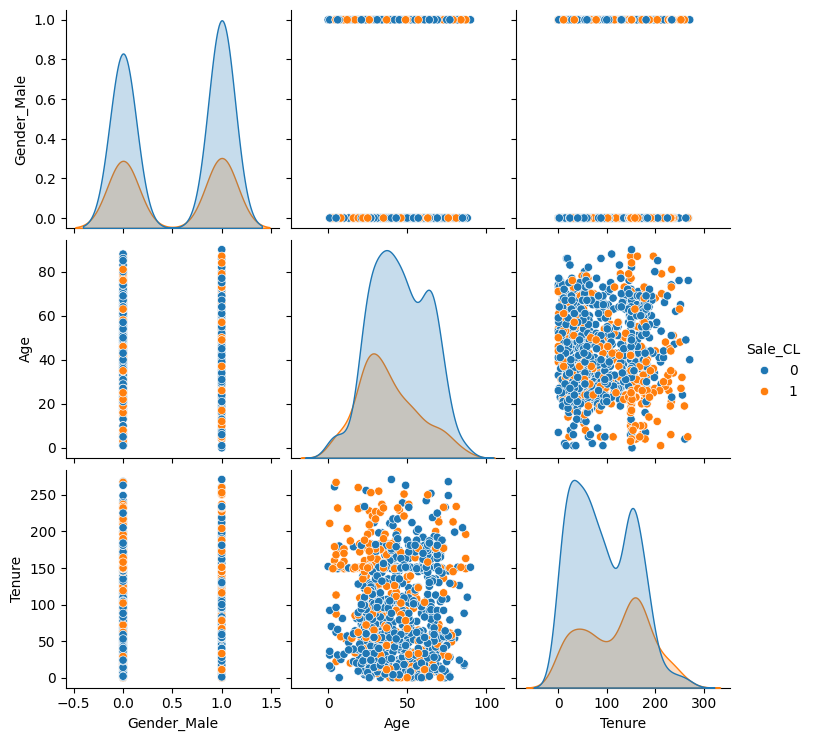

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_pair_plots (target = 'Sale_CL',selected_field=['Gender_Male','Age','Tenure']):
    
    return sns.pairplot(df_merged_targets[[target]+selected_field],hue=target)


selected_demog=['Gender_Male','Age','Tenure']


#plot Sae MF versus Demog

plot_pair_plots('Sale_CL',selected_demog)

In [ ]:
selected_bal=['Count_CA','Count_SA','Count_MF','Count_OVD','Count_CC','Count_CL','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL'  ]

selected_inout=['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder',
'TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder'  ]


AllTxnBalances = selected_bal + selected_inout

#plot Sae MF versus Products_ActBalance and Inout
plot_pair_plots('Sale_CL',AllTxnBalances)

<Axes: >

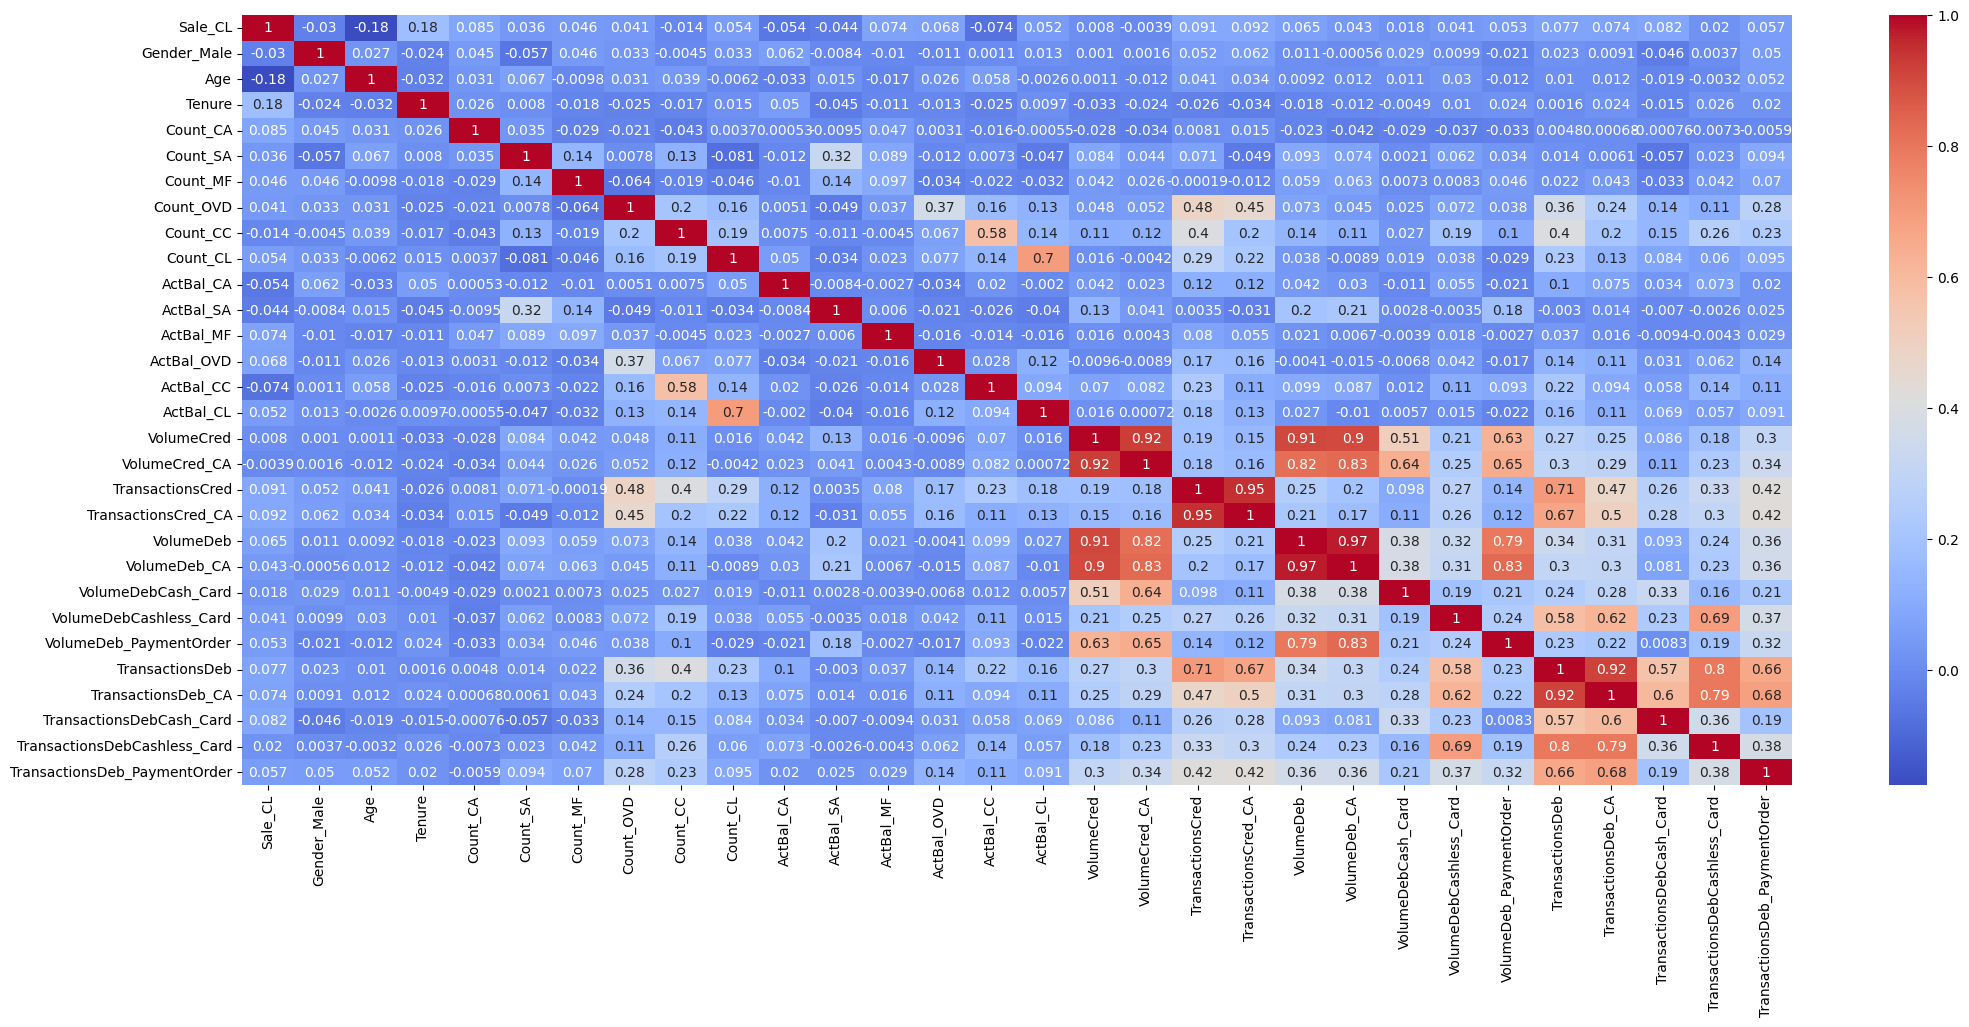

In [15]:
target = 'Sale_CL'

AllTxnBalancesdemog = selected_demog+selected_bal + selected_inout 

fig, ax = plt.subplots(figsize=(25, 10))
corr_matrix = df_merged_targets[[target]+AllTxnBalancesdemog].corr(numeric_only=True)

sns.heatmap(corr_matrix,cmap='coolwarm', annot=True)


<Axes: >

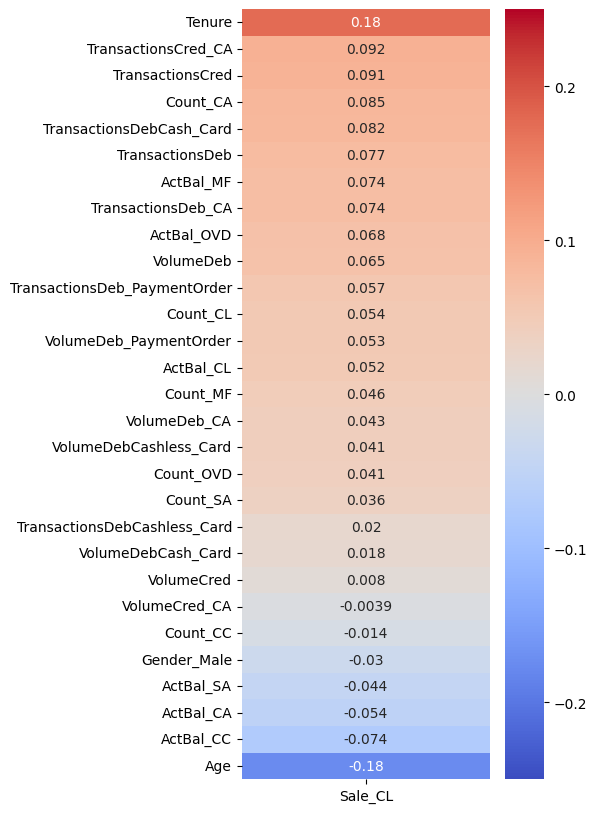

In [16]:
fig, ax = plt.subplots(figsize=(4, 10))
corr_matrix = df_merged_targets[[target]+AllTxnBalancesdemog].corr(numeric_only=True).sort_values(by=target,ascending=False)
corr_matrix_dead = corr_matrix.drop(target)
sns.heatmap(corr_matrix_dead[[target]],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

# 4. Test Train Split



In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error,roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,  roc_curve, auc




X = df_merged_targets.drop(['Client','Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL'],axis=1)


#CLassification Targets

y_MF= df_merged_targets['Sale_MF']
y_CC= df_merged_targets['Sale_CC']
y_CL= df_merged_targets['Sale_CL']




# Train and Test Split

X_train, X_test, y_train_MF, y_test_MF, y_train_CC, y_test_CC, y_train_CL, y_test_CL  = train_test_split(X, y_MF, y_CC, y_CL,test_size=0.2, random_state=42)



#Check if class share is comparable between train and test

print("Share of MF in train and test data set")
print(y_test_MF.sum()/len(y_test_MF))
print(y_train_MF.sum()/len(y_train_MF))

print("----------------------------","\n")
print("Share of CC in train and test data set")
print(y_test_CC.sum()/len(y_test_CC))
print(y_train_CC.sum()/len(y_train_CC))

print("----------------------------","\n")
print("Share of CL in train and test data set")
print(y_test_CL.sum()/len(y_test_CL))
print(y_train_CL.sum()/len(y_train_CL))




Share of MF in train and test data set
0.18556701030927836
0.20258064516129032
---------------------------- 

Share of CC in train and test data set
0.25257731958762886
0.24903225806451612
---------------------------- 

Share of CL in train and test data set
0.25773195876288657
0.3096774193548387


In [31]:
# Shape of MF training double check if matching
print(X_train.shape)
print(y_train_MF.shape)

# Shape of CC training double check if matching
print(y_train_CC.shape)

# Shape of CC training double check if matching
print(y_train_CL.shape)



(775, 29)
(775,)
(775,)
(775,)


In [32]:
# y_train_MF
# y_train_CC
y_train_CL

722    0
192    1
947    0
568    0
451    0
      ..
106    1
270    0
860    0
435    0
102    0
Name: Sale_CL, Length: 775, dtype: int64

In [33]:
df_merged_targets['Sale_CL'].iloc[106]
# df_merged_targets['Sale_CL']

1

# 5. Model Selection - Classfication

1. Choose from model that will perform well on class-imbalanced data, skewed distribution and outliers and presence of multicolinearity 
2. Tree based model are good options. I've evaluated logistic regression just as reference. LR may result in overfit unless feature reduction is done (Extra steps and less performance)
3. Will train 3 classification models for Sale_MF, Sale_CC and Sale_CL and fine tune each's best performer



## 5A Model Selection Function

In [21]:

# Define Candidate the models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),  # reference only will not use
    "Random Forest": RandomForestClassifier(n_estimators=200,random_state=42),
    'Decision Tree':DecisionTreeClassifier(random_state=4),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42)
}

def eval_candidate_model(models, X_train, y_train, y_test):
    # Initialize a dictionary to store AUC - ROC scores
    roc_auc_scores = {}
    recall_scores={}
    f1_scores={}
    class_report={}

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict label
        y_pred = model.predict(X_test)
        # Predict the probabilities
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Calculate the AUC - ROC score
        roc_auc = roc_auc_score(y_test, y_probs)
        roc_auc_scores[name] = roc_auc

        # # Calculate accuracy recall F1 Score
        # recall = recall_score(y_test, y_pred, average="macro")
        # recall_scores[name] = recall

        # f1score = f1_score(y_test, y_pred, average="macro")
        # f1_scores[name] = f1score

        print(f'{name}: AUC - ROC = {roc_auc:.2f}')
        print(' ')
        print(f'{name}: class report')
        print(classification_report(y_test, y_pred))
        print('--------------------------------------')
        


        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()




## 5B. Classification Selection for Sale_MF

Logistic Regression: AUC - ROC = 0.68
 
Logistic Regression: class report
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       158
           1       0.83      0.14      0.24        36

    accuracy                           0.84       194
   macro avg       0.83      0.57      0.57       194
weighted avg       0.83      0.84      0.78       194

--------------------------------------
Random Forest: AUC - ROC = 0.64
 
Random Forest: class report
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       158
           1       0.56      0.14      0.22        36

    accuracy                           0.82       194
   macro avg       0.69      0.56      0.56       194
weighted avg       0.78      0.82      0.77       194

--------------------------------------
Decision Tree: AUC - ROC = 0.56
 
Decision Tree: class report
              precision    recall  f1-score   support

           0   

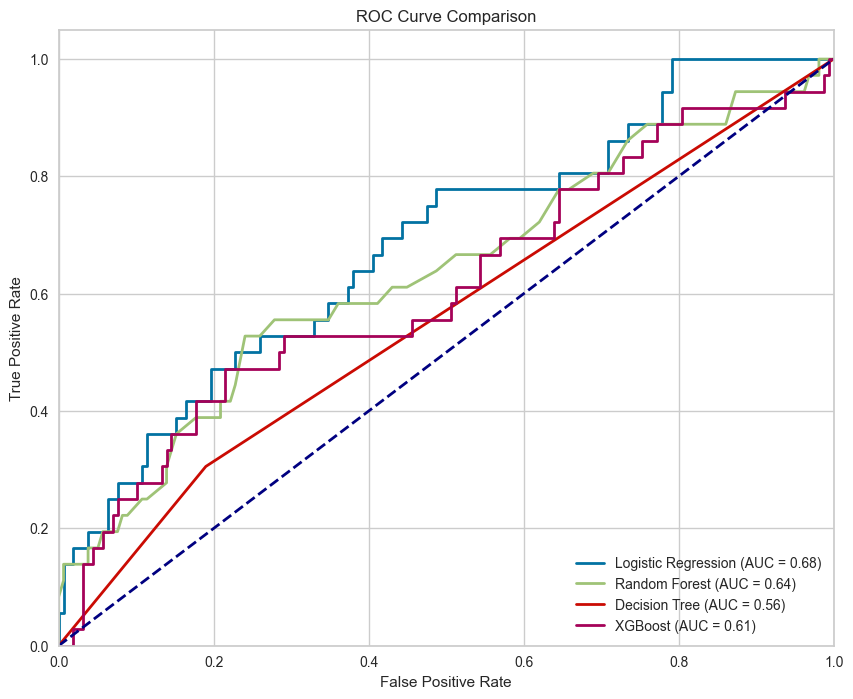

In [42]:
eval_candidate_model(models, X_train, y_train_MF, y_test_MF)

## 5C. Classification Selection for Sale_CC

Logistic Regression: AUC - ROC = 0.62
 
Logistic Regression: class report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       145
           1       0.67      0.20      0.31        49

    accuracy                           0.77       194
   macro avg       0.72      0.58      0.59       194
weighted avg       0.75      0.77      0.72       194

--------------------------------------
Random Forest: AUC - ROC = 0.57
 
Random Forest: class report
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       145
           1       0.79      0.22      0.35        49

    accuracy                           0.79       194
   macro avg       0.79      0.60      0.61       194
weighted avg       0.79      0.79      0.74       194

--------------------------------------
Decision Tree: AUC - ROC = 0.51
 
Decision Tree: class report
              precision    recall  f1-score   support

           0   

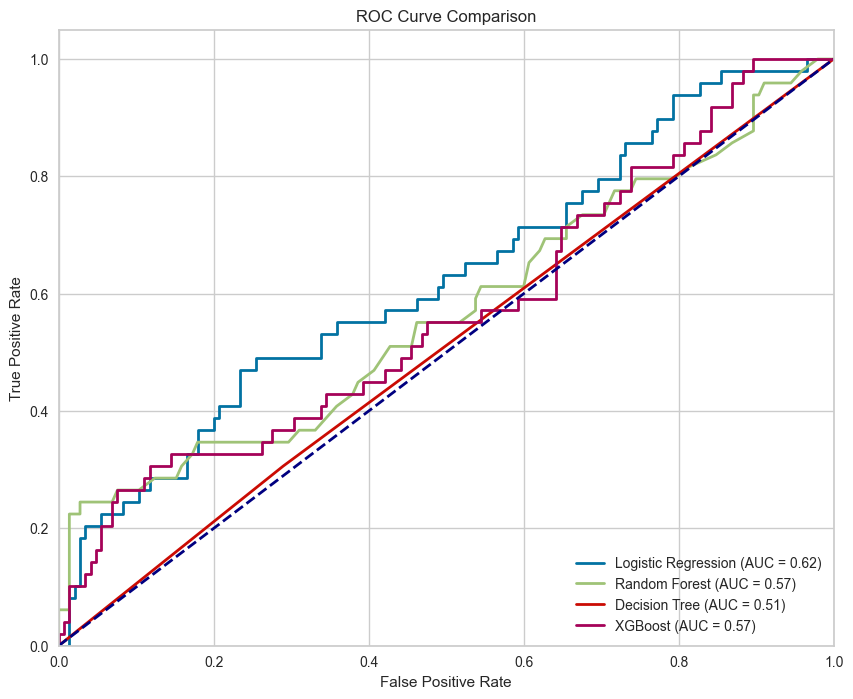

In [44]:
eval_candidate_model(models, X_train, y_train_CC, y_test_CC)

## 5D. Classification Selection for Sale_CL

Logistic Regression: AUC - ROC = 0.66
 
Logistic Regression: class report
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       144
           1       0.76      0.32      0.45        50

    accuracy                           0.80       194
   macro avg       0.78      0.64      0.66       194
weighted avg       0.79      0.80      0.77       194

--------------------------------------
Random Forest: AUC - ROC = 0.58
 
Random Forest: class report
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       144
           1       0.47      0.18      0.26        50

    accuracy                           0.74       194
   macro avg       0.62      0.56      0.55       194
weighted avg       0.69      0.74      0.69       194

--------------------------------------
Decision Tree: AUC - ROC = 0.57
 
Decision Tree: class report
              precision    recall  f1-score   support

           0   

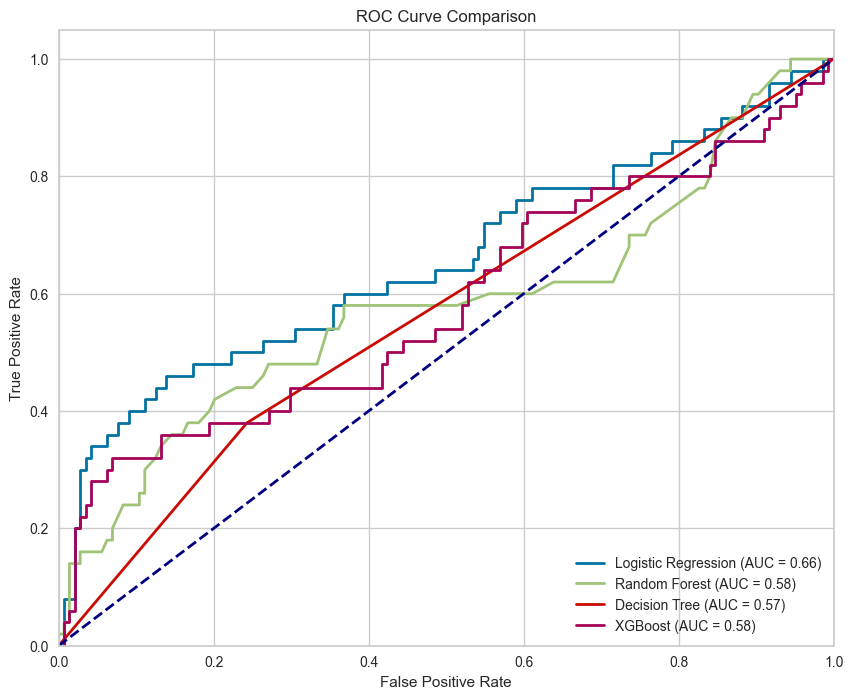

In [45]:
eval_candidate_model(models, X_train, y_train_CL, y_test_CL)

## 5E Logistic Regression LOOKED OK HOWEVER this may be an overfitted model with multicollinear variables being used

1. Tested with reduced variables / Feautures using PCA
2. Results using reduced variables did not perform better than Tree based and ensemble models
3. Will opt out with LR

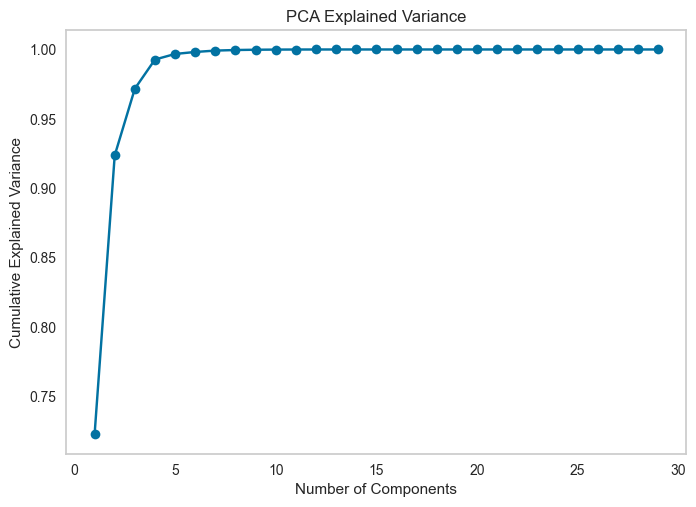

Optimal number of PCA components: 13


In [46]:
# Finding the optimal number of PCA components using the elbow method
pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Determine the optimal number of components (elbow point)
optimal_num_components = np.where(cumulative_explained_variance >= 0.99999)[0][0] + 1

print(f"Optimal number of PCA components: {optimal_num_components}")

In [47]:
# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_num_components, svd_solver="full")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit a Decision Tree Classifier on the PCA-transformed dataset
pca_logreg = LogisticRegression(solver='liblinear', max_iter=1000)#DecisionTreeClassifier(random_state=42)
pca_logreg.fit(X_train_pca, y_train_MF)

# Predictions on the PCA-transformed dataset
pca_predictions = pca_logreg.predict(X_test_pca)
y_probs = pca_logreg.predict_proba(X_test_pca)[:, 1]



# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test_MF, y_probs)

print('AUC-ROC Score:')
print(roc_auc)

print('--------------------')
print('Classification Report:')
print(classification_report(y_test_MF, pca_predictions))


AUC-ROC Score:
0.57471870604782
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       158
           1       1.00      0.06      0.11        36

    accuracy                           0.82       194
   macro avg       0.91      0.53      0.50       194
weighted avg       0.86      0.82      0.75       194



# 6. Fine Tuning and Model Finalization

For ease, XGBoost will be selected for MF, CC and CL since it works well for three marketing targets

In [48]:
from scipy.stats import randint, uniform

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='macro')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [79]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train_CL)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)


# random_search.fit(X_train, y_train_MF)

''''Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.947522980551238, 'gamma': 0.04126974737462186, 'learning_rate': 0.2764673282061002, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 172, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.4718429748376137}
Best cross-validation score:  0.514771014816688'''


# random_search.fit(X_train, y_train_CC)
''' 
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.947522980551238, 'gamma': 0.04126974737462186, 'learning_rate': 0.2764673282061002, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 172, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.4718429748376137}
Best cross-validation score:  0.5715039516352206
'''


# random_search.fit(X_train, y_train_CL)
''' 
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.6182538843378929, 'gamma': 0.3365542148887265, 'learning_rate': 0.20015956426041523, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.6928903586919394}
Best cross-validation score:  0.609926478178053
'''

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.6182538843378929, 'gamma': 0.3365542148887265, 'learning_rate': 0.20015956426041523, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.6928903586919394}
Best cross-validation score:  0.609926478178053


" \nFitting 5 folds for each of 2000 candidates, totalling 10000 fits\nBest parameters found:  {'colsample_bytree': 0.6182538843378929, 'gamma': 0.3365542148887265, 'learning_rate': 0.20015956426041523, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.6928903586919394}\nBest cross-validation score:  0.609926478178053\n"

## 6A Use Random Search Result as midpoint in GridSearch


In [81]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [145, 164, 175],
    'max_depth': [9, 10, 11],
    'learning_rate': [0.19, 0.20, 0.21],
    'subsample': [0.66, 0.69, 0.72],
    'colsample_bytree': [0.6, 0.62, 0.64],
    'gamma': [0.32, 0.34, 0.36],
    'min_child_weight': [2],
    'reg_alpha': [6],
    'reg_lambda': [3]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='macro')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)


# Fit the model using gRIDSearchCV
# grid_search.fit(X_train, y_train_MF)

'''
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.06, 'learning_rate': 0.26, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.45}
Best cross-validation score:  0.5552675869806196
'''

# grid_search.fit(X_train, y_train_CC)


''' Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.95, 'gamma': 0.02, 'learning_rate': 0.27, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.45}
Best cross-validation score:  0.6018610704843728'''


grid_search.fit(X_train, y_train_CL)
''' 
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.64, 'gamma': 0.32, 'learning_rate': 0.19, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.72}
Best cross-validation score:  0.6327116577188192
'''

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.64, 'gamma': 0.32, 'learning_rate': 0.19, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.72}
Best cross-validation score:  0.6327116577188192


## 6B Finalize Sale_MF model

In [27]:
#'colsample_bytree': 1.0, 'gamma': 0.06, 'learning_rate': 0.26, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.45

classMF_xgTuned = XGBClassifier(colsample_bytree=1,
                                gamma=0.06,
                                learning_rate=0.26,
                                max_depth=8,
                                min_child_weight=1,
                                n_estimators=200,
                                 reg_alpha= 7, reg_lambda= 0, subsample= 0.45


                                )


classMF_xgTuned.fit(X_train, y_train_MF)

y_pred_tuned = classMF_xgTuned.predict(X_test) 

y_probs = classMF_xgTuned.predict_proba(X_test)[:, 1]



# Calculate the AUC - ROC score
print(f'Tuned AUC - ROC = {roc_auc_score(y_test_MF, y_probs)}')
print(' ')
print('Tuned Class Report')
print(classification_report(y_test_MF,y_pred_tuned)) 




Tuned AUC - ROC = 0.6700070323488045
 
Tuned Class Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       158
           1       0.36      0.11      0.17        36

    accuracy                           0.80       194
   macro avg       0.59      0.53      0.53       194
weighted avg       0.74      0.80      0.75       194



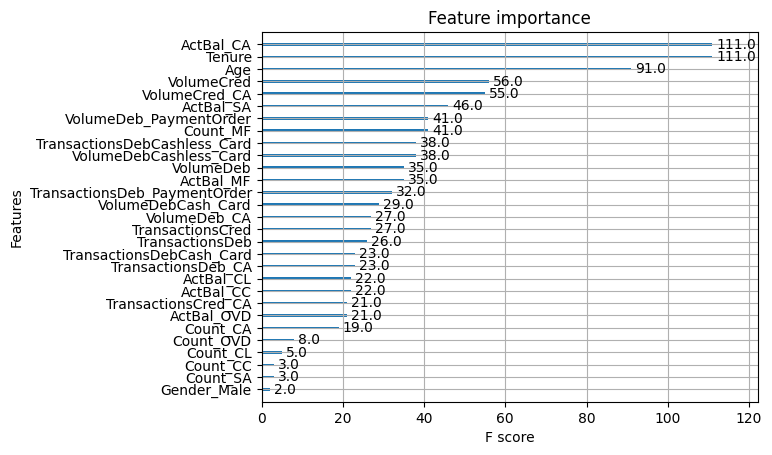

In [34]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
# plot
plot_importance(classMF_xgTuned)
plt.show()

XGBoostMF: AUC - ROC = 0.61
 
XGBoostMF: class report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       158
           1       0.46      0.17      0.24        36

    accuracy                           0.81       194
   macro avg       0.65      0.56      0.57       194
weighted avg       0.77      0.81      0.77       194

--------------------------------------
XGBoost_tuned_MF: AUC - ROC = 0.67
 
XGBoost_tuned_MF: class report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       158
           1       0.36      0.11      0.17        36

    accuracy                           0.80       194
   macro avg       0.59      0.53      0.53       194
weighted avg       0.74      0.80      0.75       194

--------------------------------------


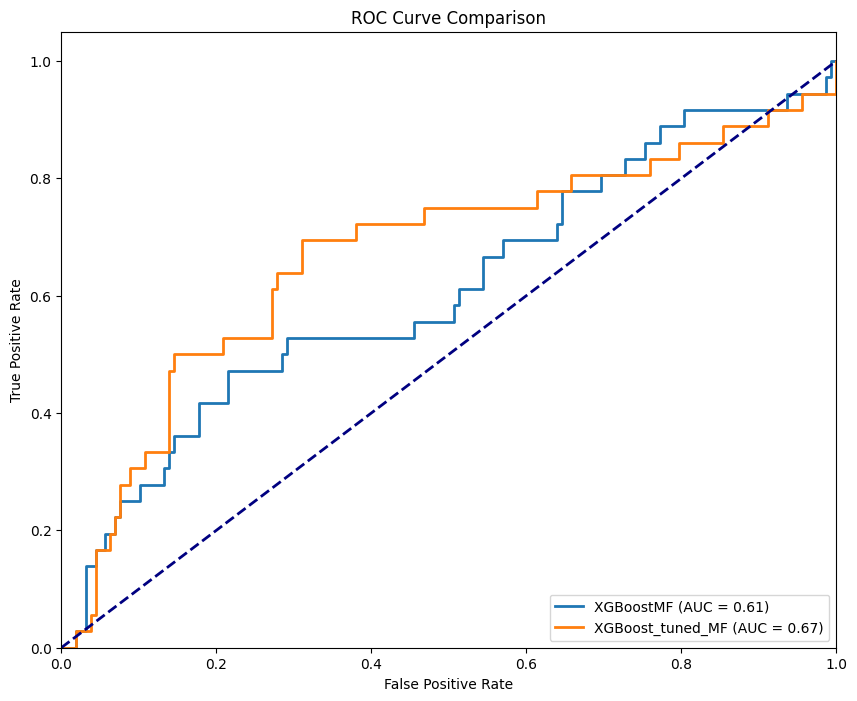

In [25]:
# Define Candidate the models
modelsMF = {
    'XGBoostMF': XGBClassifier(n_estimators=200, random_state=42),
    'XGBoost_tuned_MF': XGBClassifier(colsample_bytree=1,
                                gamma=0.06,
                                learning_rate=0.26,
                                max_depth=8,
                                min_child_weight=1,
                                n_estimators=200,
                                 reg_alpha= 7, reg_lambda= 0, subsample= 0.45


                                )
}

eval_candidate_model(modelsMF, X_train, y_train_MF, y_test_MF)

## 6C Finalize Sale_CC model



In [28]:
#Fitting 5 folds for each of 729 candidates, totalling 3645 fits
# Best parameters found:  {'colsample_bytree': 0.95, 'gamma': 0.02, 'learning_rate': 0.27, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.45}
# Best cross-validation score:  0.6018610704843728

classCC_xgTuned = XGBClassifier(colsample_bytree=0.95,
                                gamma=0.02,
                                learning_rate=0.27,
                                max_depth=6,
                                min_child_weight=1,
                                n_estimators=200,
                                 reg_alpha= 7, reg_lambda= 0, subsample= 0.45


                                )


classCC_xgTuned.fit(X_train, y_train_CC)

y_pred_tuned = classCC_xgTuned.predict(X_test) 

y_probs = classCC_xgTuned.predict_proba(X_test)[:, 1]



# Calculate the AUC - ROC score
print(f'Tuned AUC - ROC = {roc_auc_score(y_test_CC, y_probs)}')
print(' ')
print('Tuned Class Report')
print(classification_report( y_test_CC,y_pred_tuned)) 




Tuned AUC - ROC = 0.607600281491907
 
Tuned Class Report
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       145
           1       0.54      0.29      0.37        49

    accuracy                           0.76       194
   macro avg       0.67      0.60      0.61       194
weighted avg       0.73      0.76      0.73       194



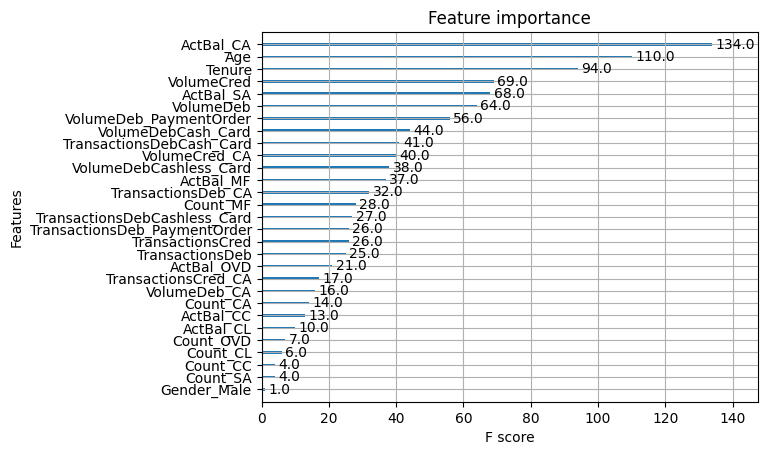

In [32]:
# plot
plot_importance(classCC_xgTuned)
plt.show()

XGBoostCC: AUC - ROC = 0.57
 
XGBoostCC: class report
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       145
           1       0.55      0.24      0.34        49

    accuracy                           0.76       194
   macro avg       0.67      0.59      0.59       194
weighted avg       0.72      0.76      0.72       194

--------------------------------------
XGBoost_tuned_CC: AUC - ROC = 0.61
 
XGBoost_tuned_CC: class report
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       145
           1       0.54      0.29      0.37        49

    accuracy                           0.76       194
   macro avg       0.67      0.60      0.61       194
weighted avg       0.73      0.76      0.73       194

--------------------------------------


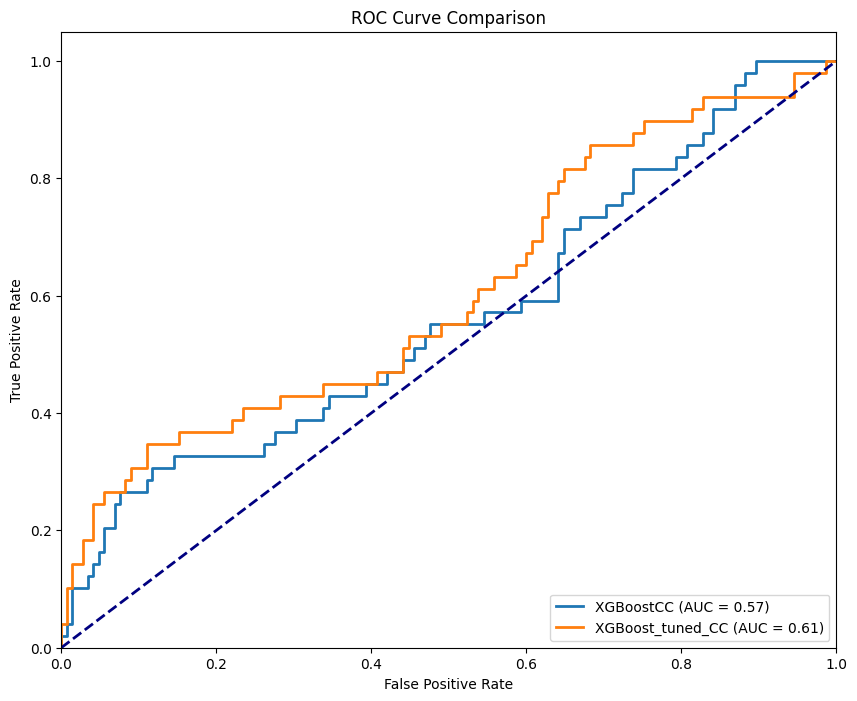

In [29]:
# Define Candidate the models
modelsMF = {
    'XGBoostCC': XGBClassifier(n_estimators=200, random_state=42),
    'XGBoost_tuned_CC': XGBClassifier(colsample_bytree=0.95,
                                gamma=0.02,
                                learning_rate=0.27,
                                max_depth=6,
                                min_child_weight=1,
                                n_estimators=200,
                                 reg_alpha= 7, reg_lambda= 0, subsample= 0.45


                                )
}

eval_candidate_model(modelsMF, X_train, y_train_CC, y_test_CC)

## 6D Finalize Sale_CL model


In [30]:
''' 
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.64, 'gamma': 0.32, 'learning_rate': 0.19, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 164, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.72}
Best cross-validation score:  0.6327116577188192
'''



classCL_xgTuned = XGBClassifier(colsample_bytree=0.64,
                                gamma=0.32,
                                learning_rate=0.19,
                                max_depth=9,
                                min_child_weight=2,
                                n_estimators=164,
                                 reg_alpha= 6, reg_lambda= 3, subsample= 0.72


                                )


classCL_xgTuned.fit(X_train, y_train_CL)

y_pred_tuned = classCL_xgTuned.predict(X_test) 

y_probs = classCL_xgTuned.predict_proba(X_test)[:, 1]



# Calculate the AUC - ROC score
print(f'Tuned AUC - ROC = {roc_auc_score(y_test_CL, y_probs)}')
print(' ')
print('Tuned Class Report')
print(classification_report(y_test_CL,y_pred_tuned)) 






Tuned AUC - ROC = 0.6322222222222222
 
Tuned Class Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       144
           1       0.62      0.30      0.41        50

    accuracy                           0.77       194
   macro avg       0.71      0.62      0.63       194
weighted avg       0.75      0.77      0.74       194



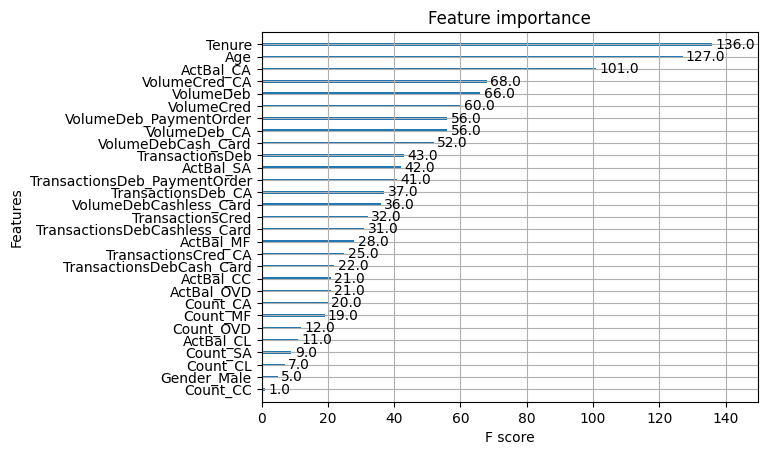

In [33]:
# plot
plot_importance(classCL_xgTuned)
plt.show()

XGBoostCL: AUC - ROC = 0.58
 
XGBoostCL: class report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       144
           1       0.50      0.32      0.39        50

    accuracy                           0.74       194
   macro avg       0.65      0.60      0.61       194
weighted avg       0.72      0.74      0.72       194

--------------------------------------
XGBoost_tuned_CL: AUC - ROC = 0.63
 
XGBoost_tuned_CL: class report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       144
           1       0.62      0.30      0.41        50

    accuracy                           0.77       194
   macro avg       0.71      0.62      0.63       194
weighted avg       0.75      0.77      0.74       194

--------------------------------------


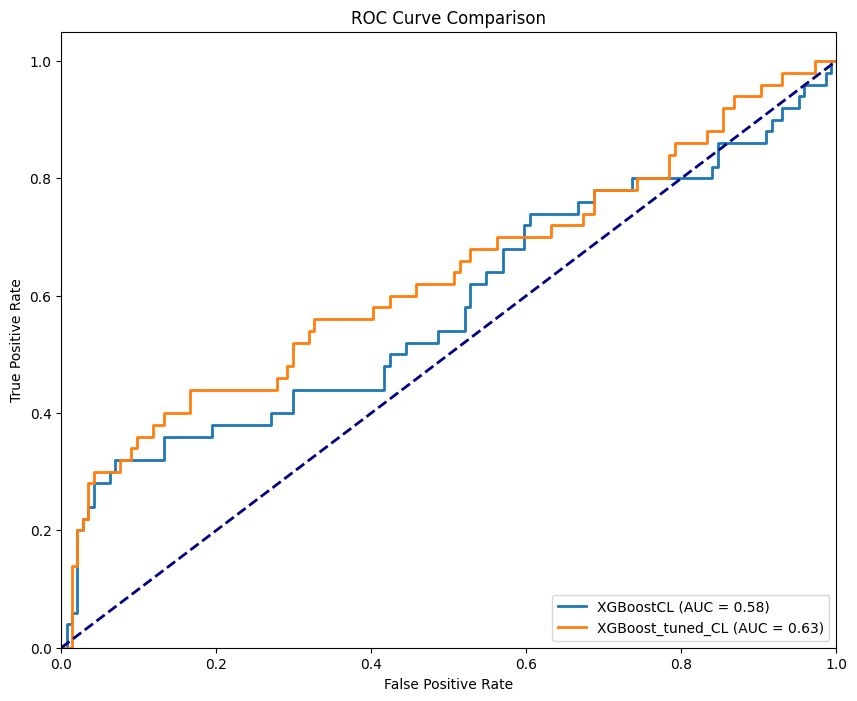

In [31]:
# Define Candidate the models
modelsMF = {
    'XGBoostCL': XGBClassifier(n_estimators=200, random_state=42),
    'XGBoost_tuned_CL': XGBClassifier(colsample_bytree=0.64,
                                gamma=0.32,
                                learning_rate=0.19,
                                max_depth=9,
                                min_child_weight=2,
                                n_estimators=164,
                                 reg_alpha= 6, reg_lambda= 3, subsample= 0.72



                                )
}

eval_candidate_model(modelsMF, X_train, y_train_CL, y_test_CL)

## 6E Save Finalized Class Models

In [84]:
##########################
# SAVE-LOAD using joblib #
##########################
import joblib

# save FINAL_MF
# joblib.dump(classMF_xgTuned, "classMF_xgTuned.pkl") 


# save FINAL_CC
# joblib.dump(classCC_xgTuned, "classCC_xgTuned.pkl") 

# save FINAL_CL
joblib.dump(classCL_xgTuned, "classCL_xgTuned.pkl") 

# # load
# clf2 = joblib.load("model.pkl")




['classCL_xgTuned.pkl']

# 7 SCORE Prospects

1. Assumed that the prospects needing to be identified are those not in TARGET data set

In [ ]:
import joblib


 # load Models
classMF_xgTunedLoaded = joblib.load("classMF_xgTuned.pkl")
classCC_xgTunedLoaded = joblib.load("classCC_xgTuned.pkl")
classCL_xgTunedLoaded = joblib.load("classCL_xgTuned.pkl")

In [72]:
# def Clean_Data(df):

# Take OUT NOT SEEN IN TARGET DATASETS

df_merged_to_Score = pd.merge(df_merged_ind, df_target, on=['Client'], how="outer", indicator=True
              ).query('_merge=="left_only"')

df_merged_to_Score_feed=df_merged_to_Score.drop(['Client','Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC',
       'Revenue_CL','_merge'], axis=1)
df_merged_to_Score_feed.reset_index()
df_merged_to_Score_feed

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Gender_Male
0,21,27,1,0.0,0.0,1.0,0.0,1.0,4.710714,0.0,...,448.892857,178.571429,0.000000,166.571429,8.0,7.0,1.0,0.0,4.0,True
6,37,175,1,0.0,4.0,1.0,0.0,0.0,1823.057143,0.0,...,566.126071,89.285714,0.000000,216.892857,13.0,10.0,2.0,0.0,5.0,True
9,19,70,1,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,390.056429,125.000000,70.842143,190.821429,10.0,10.0,4.0,3.0,2.0,False
10,61,45,1,0.0,0.0,0.0,0.0,0.0,324.710000,0.0,...,3.392857,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,True
13,41,28,1,0.0,0.0,0.0,0.0,0.0,17.051071,0.0,...,557.896429,71.428571,224.146429,251.178571,17.0,17.0,2.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,33,82,1,0.0,0.0,1.0,0.0,0.0,352.782143,0.0,...,934.384643,0.000000,0.000000,0.000000,9.0,5.0,0.0,0.0,0.0,False
1600,65,13,1,0.0,0.0,0.0,0.0,0.0,193.040000,0.0,...,109.107143,107.142857,0.000000,0.000000,3.0,3.0,2.0,0.0,0.0,True
1608,68,153,2,0.0,0.0,1.0,0.0,0.0,2249.049643,0.0,...,577.385714,160.714286,65.421429,347.857143,12.0,12.0,2.0,3.0,6.0,True
1610,31,91,1,0.0,0.0,1.0,0.0,0.0,348.402857,0.0,...,465.092857,178.571429,11.414286,271.714286,12.0,12.0,1.0,1.0,9.0,True


## 7A Predict all prospects

In [75]:


df_prospects = df_merged_to_Score[['Client']].reset_index()
df_prospects['MF_Prospect']= pd.DataFrame(classMF_xgTunedLoaded.predict(df_merged_to_Score_feed))
df_prospects['MF_Prospect_prob']= pd.DataFrame(classMF_xgTunedLoaded.predict_proba(df_merged_to_Score_feed)[:, 1])
df_prospects['CC_Prospect']= pd.DataFrame(classCC_xgTunedLoaded.predict(df_merged_to_Score_feed))
df_prospects['CC_Prospect_prob']= pd.DataFrame(classCC_xgTunedLoaded.predict_proba(df_merged_to_Score_feed)[:, 1])
df_prospects['CL_Prospect']= pd.DataFrame(classCL_xgTunedLoaded.predict(df_merged_to_Score_feed))
df_prospects['CL_Prospect_prob']= pd.DataFrame(classCL_xgTunedLoaded.predict_proba(df_merged_to_Score_feed)[:, 1])
df_prospects


,index,Client,MF_Prospect,MF_Prospect_prob,CC_Prospect,CC_Prospect_prob,CL_Prospect,CL_Prospect_prob
0,0,909,0,0.109113,0,0.125568,0,0.429895
1,6,699,0,0.181360,0,0.325903,1,0.618366
2,9,528,0,0.080925,0,0.083634,1,0.773133
3,10,1145,0,0.213927,0,0.170184,0,0.103273
4,13,517,0,0.186669,0,0.255476,1,0.700741
...,...,...,...,...,...,...,...,...
641,1598,419,0,0.117637,0,0.193598,0,0.228203
642,1600,1024,0,0.082552,0,0.257825,0,0.114190
643,1608,464,0,0.061454,0,0.355911,0,0.289812
644,1610,409,0,0.031309,0,0.332111,0,0.262587


## 7B Revenue Expectation

1. Assign only one product for each Prospect
2. In absensce of a feasible regressor for Revenue, NEXT BEST Estimate is the average of those with past MF/CC/CL sale.. (ex: ave revenue of All Sale_MF == 1)

In [101]:


average_MF_Revenue = df_merged_targets.Revenue_MF[df_merged_targets.Sale_MF>0].mean()
average_CC_Revenue = df_merged_targets.Revenue_CC[df_merged_targets.Sale_CC>0].mean()
average_CL_Revenue = df_merged_targets.Revenue_CL[df_merged_targets.Sale_CL>0].mean()

prod_selection = ['Mutual Fund', 'Credit Card', 'Consumer Loan']

df_prospects['Pot_MF_Rev'] = df_prospects.apply(lambda x: average_MF_Revenue if x.MF_Prospect==1 else 0, axis=1)
df_prospects['Pot_CC_Rev'] = df_prospects.apply(lambda x: average_CC_Revenue if x.CC_Prospect==1 else 0, axis=1)
df_prospects['Pot_CL_Rev'] = df_prospects.apply(lambda x: average_CL_Revenue if x.CL_Prospect==1 else 0, axis=1)
df_prospects['Pot_MAX_Rev'] = df_prospects.apply(lambda x: max(x.Pot_MF_Rev,x.Pot_CC_Rev,x.Pot_CL_Rev), axis=1)
df_prospects['One_Prod_To_Offer'] = df_prospects.apply(lambda x: prod_selection[(x.Pot_MF_Rev,x.Pot_CC_Rev,x.Pot_CL_Rev).index(max((x.Pot_MF_Rev,x.Pot_CC_Rev,x.Pot_CL_Rev)))] if x.Pot_MAX_Rev > 0 else "", axis=1)


final_df = df_prospects.sort_values(by=['Pot_MAX_Rev'], ascending=False).drop(['index'], axis=1)

final_df.to_excel("prospects_v1.xlsx")
final_df




,Client,MF_Prospect,MF_Prospect_prob,CC_Prospect,CC_Prospect_prob,CL_Prospect,CL_Prospect_prob,Pot_MF_Rev,Pot_CC_Rev,Pot_CL_Rev,Pot_MAX_Rev,One_Prod_To_Offer
375,803,0,0.250969,0,0.252572,1,0.600895,0.0,0.0,12.043067,12.043067,Consumer Loan
541,786,0,0.126729,0,0.224358,1,0.541031,0.0,0.0,12.043067,12.043067,Consumer Loan
129,524,0,0.092004,0,0.094672,1,0.903460,0.0,0.0,12.043067,12.043067,Consumer Loan
550,1319,0,0.068345,0,0.040045,1,0.659926,0.0,0.0,12.043067,12.043067,Consumer Loan
299,868,0,0.343944,0,0.422431,1,0.541078,0.0,0.0,12.043067,12.043067,Consumer Loan
...,...,...,...,...,...,...,...,...,...,...,...,...
235,487,0,0.149014,0,0.087854,0,0.099571,0.0,0.0,0.000000,0.000000,
234,1385,0,0.104669,0,0.387023,0,0.487769,0.0,0.0,0.000000,0.000000,
233,1407,0,0.137702,0,0.036147,0,0.141148,0.0,0.0,0.000000,0.000000,
231,484,0,0.238587,0,0.103186,0,0.071827,0.0,0.0,0.000000,0.000000,


# THANK YOU !!!

In [ ]:
#Regression Targets for Revenue

Abandoned, could not get a positive R2 in my experiments..
y_MF_REV= df_merged_targets['Revenue_MF']
y_CC_REV= df_merged_targets['Revenue_CC']
y_CL_REV= df_merged_targets['Revenue_CL']


# \
#     y_train_MF_REV, y_test_MF_REV, y_train_CC_REV, y_test_CC_REV, y_train_CL_REV, y_test_CL_REV  , y_MF_REV, y_CC_REV, y_CL_REV

# APPENDIX (Quick Experimentation using Visualization wrappers and SKLEARN wrappers )

## QUICK EDA

In [93]:

from autoviz import AutoViz_Class
AV = AutoViz_Class()


target = 'Sale_CL'

AllTxnBalancesdemog = selected_demog+AllTxnBalances

df = df_merged_targets[[target]+AllTxnBalancesdemog]

df[['Age', 'Tenure', 'Count_CA','Count_OVD', 'Count_CC']]=df[['Age', 'Tenure', 'Count_CA','Count_OVD', 'Count_CC']].astype(np.float64)

dft = AV.AutoViz(
    "",
    sep=",",
    depVar=target,
    dfte=df,
    header=0,
    verbose=2,
    lowess=False,
    # chart_format="html",
    chart_format="svg",
    # chart_format='bokeh',
    max_rows_analyzed=1000,
    max_cols_analyzed=36,
    save_plot_dir=None
)

Shape of your Data Set loaded: (969, 30)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Count_CA', 'Count_SA', 'Count_CL']
    Integer-Categorical Columns: []
    String-Categorical Columns: []
    Factor-Categorical Columns: []
    String-Boolean Colu

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Gender_Male,bool,0.000000,0,0.000000,1.000000,No issue
Age,float64,0.000000,NA,0.000000,90.000000,No issue
Tenure,float64,0.000000,NA,0.000000,271.000000,No issue
Count_CA,float64,0.000000,NA,1.000000,4.000000,Column has 57 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
Count_SA,float64,0.000000,NA,0.000000,3.000000,Column has 8 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them.
Count_MF,float64,0.000000,NA,0.000000,79.000000,Column has 184 outliers greater than upper bound (0.00) or lower than lower bound(0.00). Cap them or remove them.
Count_OVD,float64,0.000000,0,0.000000,1.000000,No issue
Count_CC,float64,0.000000,0,0.000000,1.000000,No issue
Count_CL,float64,0.000000,NA,0.000000,2.000000,Column has 79 outliers greater than upper bound (0.00) or lower than lower bound(0.00). Cap them or remove them.
ActBal_CA,float64,0.000000,NA,0.000000,74934.956071,Column has 99 outliers greater than upper bound (5545.74) or lower than lower bound(-3210.43). Cap them or remove them.


Total Number of Scatter Plots = 351
All Plots are saved in .\AutoViz_Plots\Sale_CL
Time to run AutoViz = 125 seconds 


## QUICK CLASSIFICATION EXPERIMENTATION

In [15]:
# init setup
from pycaret.classification import *


clf_mf = setup(data = df_merged_targets, target = 'Sale_MF',  session_id=123
            #  ,fix_imbalance=True
            # ,fix_imbalance_method='RandomOverSampler'
            # ,normalize=True
            # ,transformation=True
            # ,pca=True
            # ,feature_selection=True
            ,ignore_features =['Client','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL']
            #  ,profile=True
               )


# Compare model
bestMF = compare_models(['rf','ada','xgboost','lr','svm','dt','ridge'])

,Description,Value
0,Session id,123
1,Target,Sale_MF
2,Target type,Binary
3,Original data shape,"(969, 36)"
4,Transformed data shape,"(969, 30)"
5,Transformed train set shape,"(678, 30)"
6,Transformed test set shape,"(291, 30)"
7,Ignore features,6
8,Numeric features,28
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8082,0.5958,0.1176,0.5583,0.1935,0.1377,0.1915,0.0180
lr,Logistic Regression,0.8023,0.5940,0.1121,0.5083,0.1773,0.1190,0.1624,0.0620
rf,Random Forest Classifier,0.7995,0.5083,0.0670,0.4500,0.1131,0.0701,0.1124,1.1890
ada,Ada Boost Classifier,0.7921,0.5399,0.2011,0.4454,0.2644,0.1697,0.1907,0.7370
xgboost,Extreme Gradient Boosting,0.7773,0.5214,0.1484,0.3868,0.2064,0.1050,0.1256,0.1740
dt,Decision Tree Classifier,0.6948,0.5483,0.3044,0.2715,0.2818,0.0928,0.0940,0.0180
svm,SVM - Linear Kernel,0.6563,0.4800,0.2011,0.1565,0.1580,-0.0303,-0.0337,0.0180


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7794,0.6168,0.2308,0.3750,0.2857,0.1639,0.1707
1,0.8088,0.5846,0.2308,0.5000,0.3158,0.2218,0.2443
2,0.7794,0.5105,0.1538,0.3333,0.2105,0.1021,0.1125
3,0.8088,0.5747,0.4286,0.5455,0.4800,0.3649,0.3689
4,0.7794,0.4537,0.0714,0.3333,0.1176,0.0485,0.0677
5,0.8235,0.5906,0.2143,0.7500,0.3333,0.2662,0.3364
6,0.7500,0.4623,0.0714,0.2000,0.1053,-0.0035,-0.0041
7,0.7647,0.4213,0.0714,0.2500,0.1111,0.0216,0.0273
8,0.8060,0.6382,0.3846,0.5000,0.4348,0.3201,0.3241


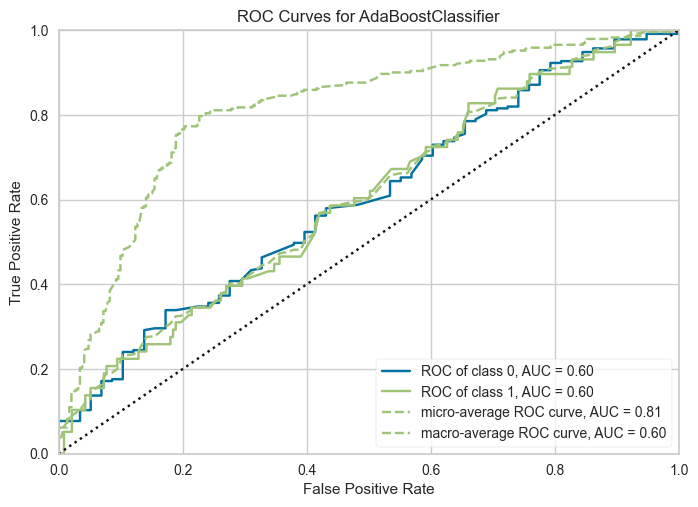

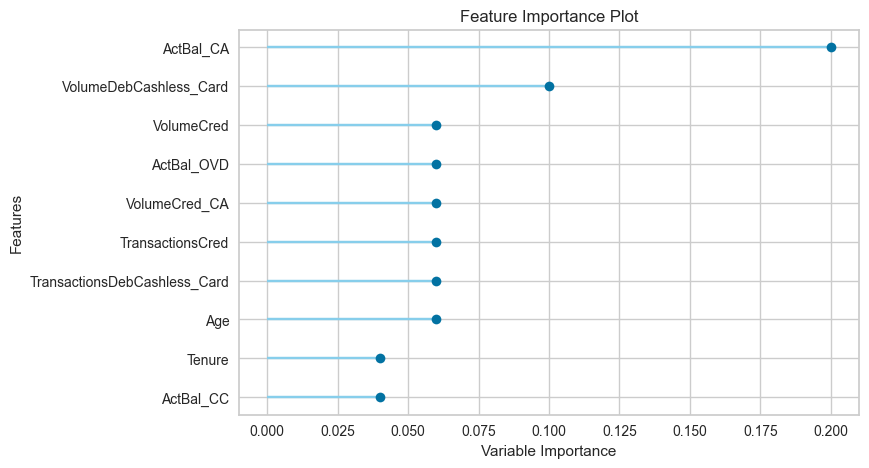

In [16]:
ada=create_model('ada')


# functional API
plot_model(ada, plot = 'auc')

plot_model(ada, plot = 'feature')

## QUICK REGRESSION EXPERIMENTATION

- Checked if REVENUE is possible to estimate with a regression, given data for SALE_MF / CC / CL > 0
- Model is not fitting well. Either there are other explanatory variables that determine Revenue OR Data is TOO sparse  190 datapoints 
- Will just estimate REVENUE BASED ON AVERAGE..  Assign AVERAGE of Revenue_MF from past client

In [35]:

from pycaret.regression import *


df_reg = df_merged_targets[df_merged_targets.Sale_MF>0]

exp_regMF = setup(data = df_reg, target = 'Revenue_MF', session_id=123,
                  normalize = True,
                 transformation = True, 
                            ignore_features =['Client', 'Sale_MF','Sale_CC','Sale_CL','Revenue_CC','Revenue_CL'],
                #             ,
                  # ,remove_multicollinearity = True
                  pca=True
                  ) 

bestRegMF=compare_models()

,Description,Value
0,Session id,123
1,Target,Revenue_MF
2,Target type,Regression
3,Original data shape,"(193, 36)"
4,Transformed data shape,"(193, 30)"
5,Transformed train set shape,"(135, 30)"
6,Transformed test set shape,"(58, 30)"
7,Ignore features,6
8,Numeric features,28
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,9.9828,533.5785,17.5698,-0.8538,1.2973,8.1659,0.0400
dummy,Dummy Regressor,10.6425,501.2268,16.6753,-0.8579,1.3355,13.6212,0.0330
omp,Orthogonal Matching Pursuit,11.4604,535.2651,18.0124,-1.5072,1.3638,15.2096,0.0300
knn,K Neighbors Regressor,11.0894,560.3254,18.1371,-1.6551,1.3978,13.5143,0.0330
catboost,CatBoost Regressor,11.3198,502.8366,17.7876,-1.9651,1.3713,15.0608,1.6840
en,Elastic Net,11.5176,528.7560,18.2794,-2.2081,1.3844,16.0649,0.0330
br,Bayesian Ridge,11.7585,544.3868,18.5562,-2.3145,1.4203,16.2804,0.0310
par,Passive Aggressive Regressor,13.4790,589.7765,19.8322,-2.3443,1.3485,10.4308,0.0320
ada,AdaBoost Regressor,13.0766,564.5987,19.4362,-3.2686,1.5113,23.1400,0.0530
lightgbm,Light Gradient Boosting Machine,13.8174,605.1324,20.7578,-4.3091,1.5287,22.0941,0.1240


In [16]:
# init setup
from pycaret.classification import *


clf_cc = setup(data = df_merged_targets, target = 'Sale_CC',  session_id=123\
            #  ,fix_imbalance=True
            # ,fix_imbalance_method='RandomOverSampler'
            # ,normalize=True
            # ,transformation=True
            # ,pca=True
            # ,feature_selection=True
            ,ignore_features =['Client','Sale_MF','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL']
               )


# Compare model
bestCC = compare_models(['rf','ada','xgboost','lr','svm','dt'])

,Description,Value
0,Session id,123
1,Target,Sale_CC
2,Target type,Binary
3,Original data shape,"(969, 36)"
4,Transformed data shape,"(969, 30)"
5,Transformed train set shape,"(678, 30)"
6,Transformed test set shape,"(291, 30)"
7,Ignore features,6
8,Numeric features,28
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7626,0.5487,0.1599,0.6033,0.2463,0.1601,0.2112,0.0430
rf,Random Forest Classifier,0.7581,0.6145,0.1430,0.5538,0.2195,0.1375,0.1813,0.5280
ada,Ada Boost Classifier,0.7507,0.5644,0.2489,0.5152,0.3306,0.1998,0.2221,0.7550
xgboost,Extreme Gradient Boosting,0.7330,0.5943,0.2070,0.4348,0.2729,0.1374,0.1534,0.7270
dt,Decision Tree Classifier,0.6741,0.5840,0.4040,0.3644,0.3806,0.1617,0.1631,0.0150
svm,SVM - Linear Kernel,0.6412,0.5504,0.3790,0.3320,0.3366,0.1043,0.1080,0.0170


In [20]:
# init setup
from pycaret.classification import *


clf_cl = setup(data = df_merged_targets, target = 'Sale_CL',  session_id=123\
            #  ,fix_imbalance=True
            # ,fix_imbalance_method='RandomOverSampler'
            # ,normalize=True
            # ,transformation=True
            # ,pca=True
            # ,feature_selection=True
            ,ignore_features =['Client','Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL']
               )


# Compare model
bestCL= compare_models(['rf','ada','xgboost','lr','svm','dt'])

,Description,Value
0,Session id,123
1,Target,Sale_CL
2,Target type,Binary
3,Original data shape,"(969, 36)"
4,Transformed data shape,"(969, 30)"
5,Transformed train set shape,"(678, 30)"
6,Transformed test set shape,"(291, 30)"
7,Ignore features,6
8,Numeric features,28
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7552,0.6949,0.3398,0.7081,0.4355,0.3115,0.3530,0.0460
xgboost,Extreme Gradient Boosting,0.7419,0.6794,0.3743,0.6204,0.4565,0.3045,0.3254,0.7380
rf,Random Forest Classifier,0.7389,0.6745,0.2860,0.6717,0.3910,0.2590,0.3022,0.5480
ada,Ada Boost Classifier,0.6904,0.6262,0.3264,0.4760,0.3762,0.1871,0.1956,0.7800
dt,Decision Tree Classifier,0.6562,0.5943,0.4390,0.4363,0.4321,0.1883,0.1909,0.0190
svm,SVM - Linear Kernel,0.5843,0.5130,0.2867,0.3323,0.2637,0.0022,0.0098,0.0160


In [21]:
evaluate_model(bestCL)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…